# Прогнозирование уровня средней заработной платы в России

Известны данные о заработной плате за каждый месяц с января 1993 по август 2016.

Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


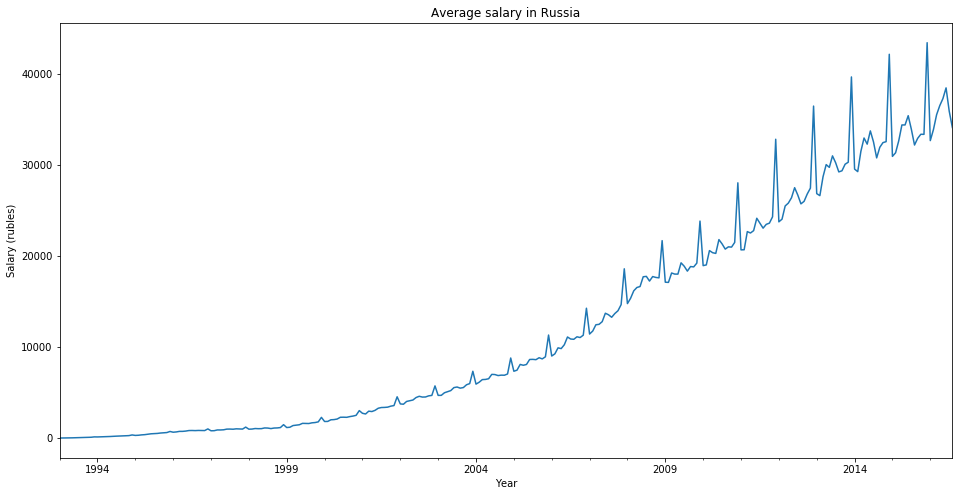

In [2]:
data = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
data.rename(columns={'WAG_C_M': 'salary'}, inplace=True)
plt.figure(figsize(16,8))
data.salary.plot()
plt.ylabel('Salary (rubles)')
plt.xlabel('Year')
plt.title('Average salary in Russia')
pylab.show()

### 1. Визуальный анализ ряда

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


<Figure size 1152x864 with 0 Axes>

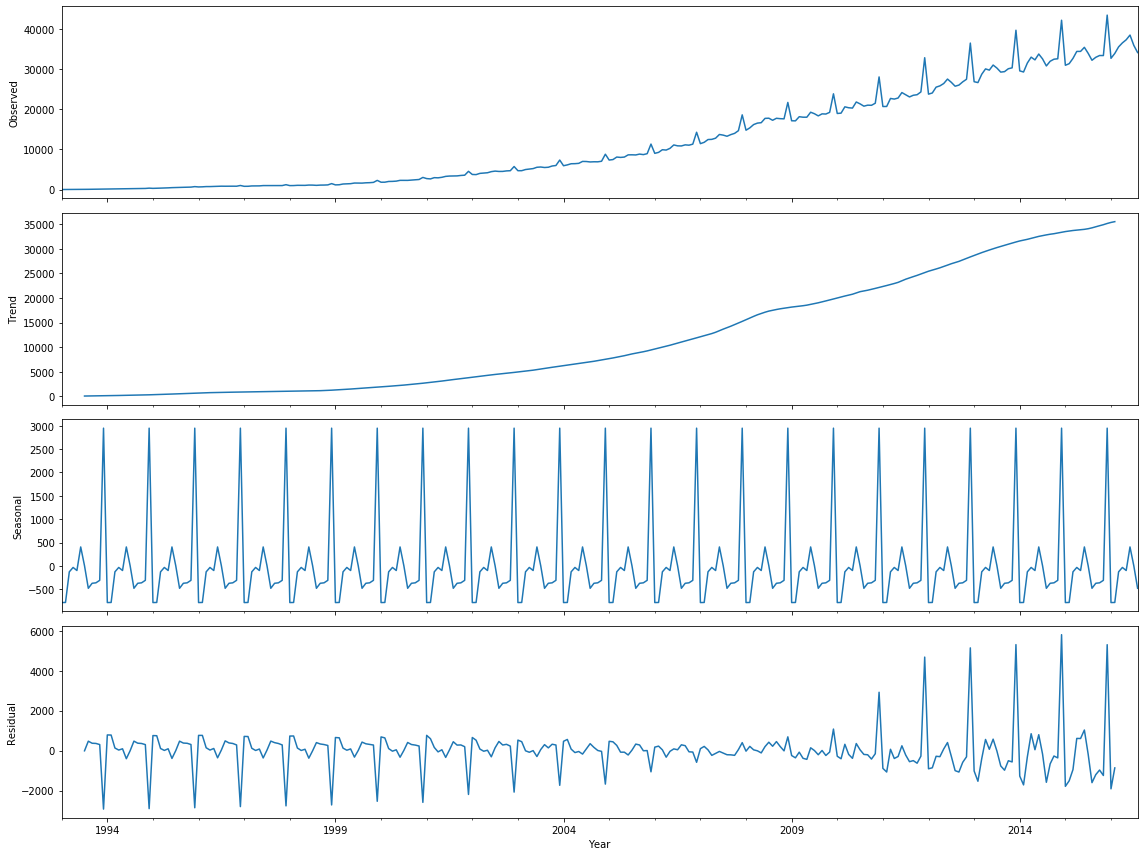

In [3]:
plt.figure(figsize(16,12))
sm.tsa.seasonal_decompose(data.salary).plot()
plt.xlabel('Year')
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.salary)[1])

### 2. Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


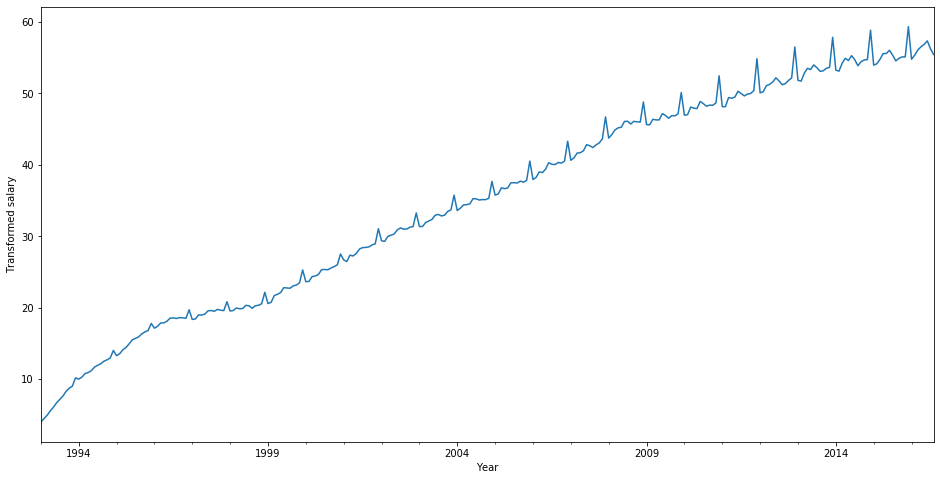

In [4]:
data['salary_box'], lmbda = stats.boxcox(data.salary)
plt.figure(figsize(16,8))
data['salary_box'].plot()
plt.ylabel(u'Transformed salary')
plt.xlabel('Year')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['salary_box'])[1])

### 3. Выбор порядка дифференцирования

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697


<Figure size 1152x864 with 0 Axes>

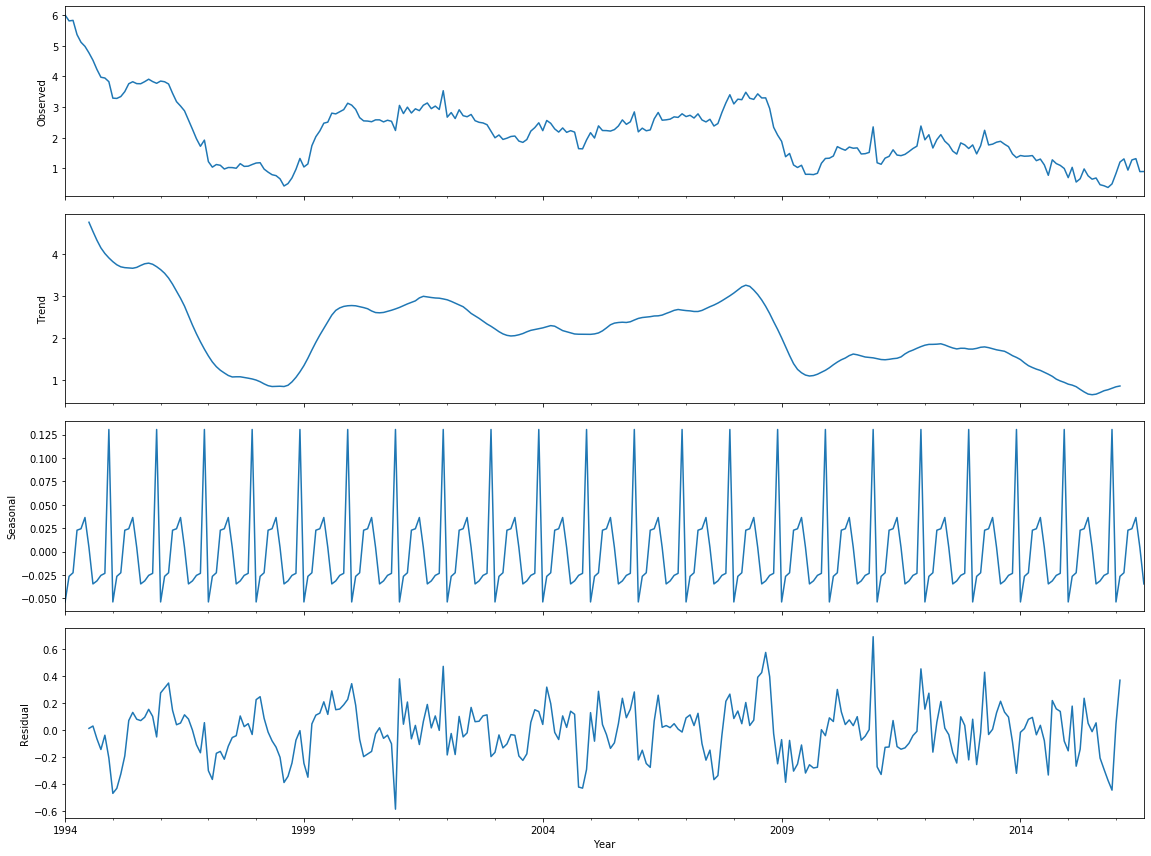

In [5]:
data['salary_box_diff'] = data['salary_box'] - data['salary_box'].shift(12)
plt.figure(figsize(16,12))
sm.tsa.seasonal_decompose(data['salary_box_diff'][12:]).plot()
plt.xlabel('Year')
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['salary_box_diff'][12:])[1])

Гипотеза о нестационарности отвергается, но полностью избавиться от тренда пока не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


<Figure size 1152x864 with 0 Axes>

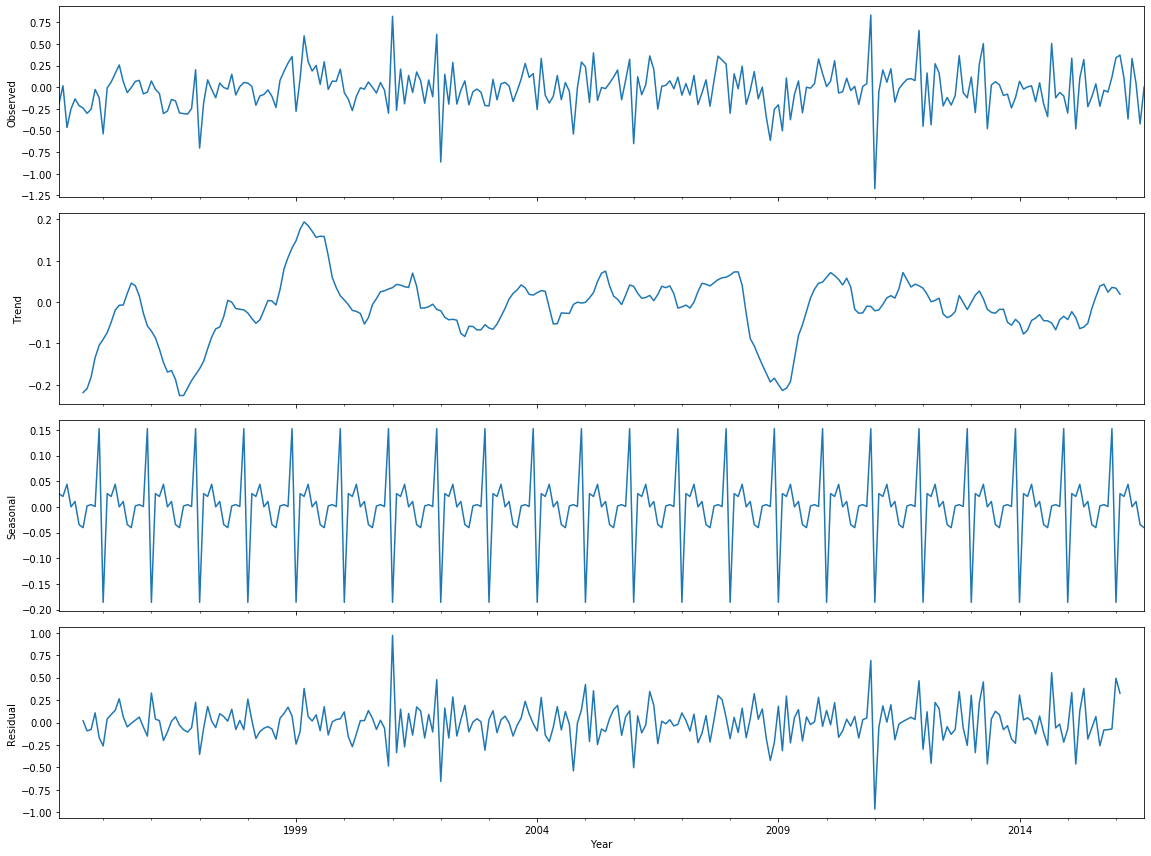

In [6]:
data['salary_box_diff2'] = data['salary_box_diff'] - data['salary_box_diff'].shift(1)
plt.figure(figsize(16,12))
sm.tsa.seasonal_decompose(data['salary_box_diff2'][13:]).plot()
plt.xlabel('Year')
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['salary_box_diff2'][13:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет. 

## 4. Выбор начальных приближений для $p, q, P, Q$

Посмотрим на ACF и PACF полученного ряда:

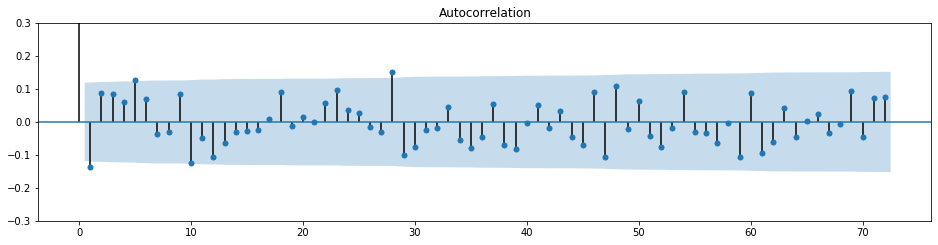

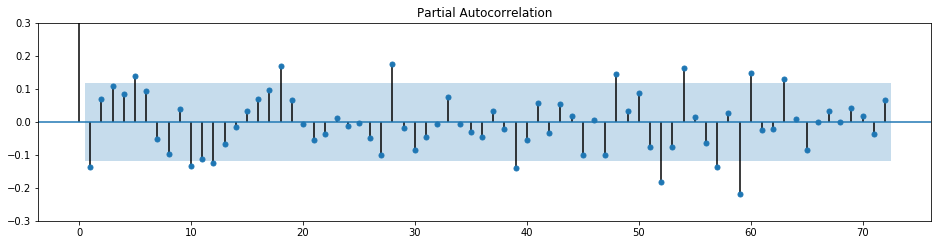

In [7]:
plt.figure(figsize(16,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data['salary_box_diff2'][13:].values.squeeze(), lags=72, ax=ax)
plt.ylim(-0.3,0.3)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data['salary_box_diff2'][13:].values.squeeze(), lags=72, ax=ax)
plt.ylim(-0.3,0.3)
pylab.show()

Начальные приближения: $Q=0, q=5, P=5, p=10$.

$Q=0$ очевидно, так как других вариантов нет. $q=5$ потому, что $q=10$ всё-таки не выходит за корридор.

$P=5$ получилось благодаря тому, что мы смотрели функции на области определения в 72 лага (а не 48, как было с вином). Посмотрим, сыграет ли это роль.

$p=10$, так как при $P>0$ мы не берём значение $p>=S$, где $S=12$ — сезонность.

### 5. Обучение и сравнение моделей-кандидатов, выбор победителя

In [8]:
Qs = range(0, 1)
qs = range(0, 6)
Ps = range(0, 6)
ps = range(0, 11)

D = 1
d = 1

In [9]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

396

In [10]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data['salary_box'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (4, 2, 1, 0)
Wall time: 1h 8min 18s


In [11]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters        aic
210  (5, 5, 1, 0) -25.144773
240  (6, 4, 1, 0) -24.940159
174  (4, 5, 1, 0) -23.923588
211  (5, 5, 2, 0) -23.420883
178  (4, 5, 5, 0) -23.213778


В итоге наши начальные приближения $Q, q$ оказались в лучшей модели, а для $P$ увеличение диапазона лагов при рассмотрении роли не сыграло (хотя одна модель с $P=5$ попала в топ-5). Также если бы мы пропустили начальное приближение $p=10$ и взяли бы $p=5$, то лучшая модель бы не изменилась, но при этом пропустили бы модель с $p=6$, которая стала топ-2.

#### Лучшая модель:

In [12]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         salary_box   No. Observations:                  284
Model:             SARIMAX(5, 1, 5)x(1, 1, 0, 12)   Log Likelihood                  24.572
Date:                            Fri, 17 Apr 2020   AIC                            -25.145
Time:                                    15:47:37   BIC                             18.081
Sample:                                01-01-1993   HQIC                            -7.789
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2209      1.174     -0.188      0.851      -2.521       2.079
ar.L2          0.2420      0.833   

### 6. Анализ остатков построенной модели

Критерий Стьюдента: p=0.169937
Критерий Дики-Фуллера: p=0.000000


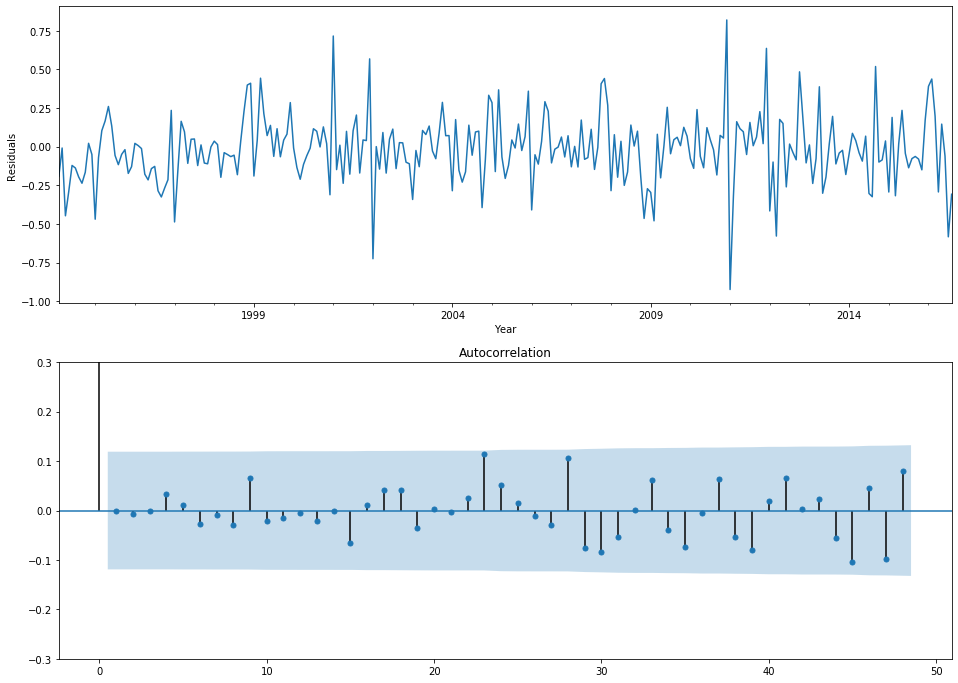

In [13]:
plt.figure(figsize(16,12))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
plt.xlabel('Year')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)
plt.ylim(-0.3,0.3)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

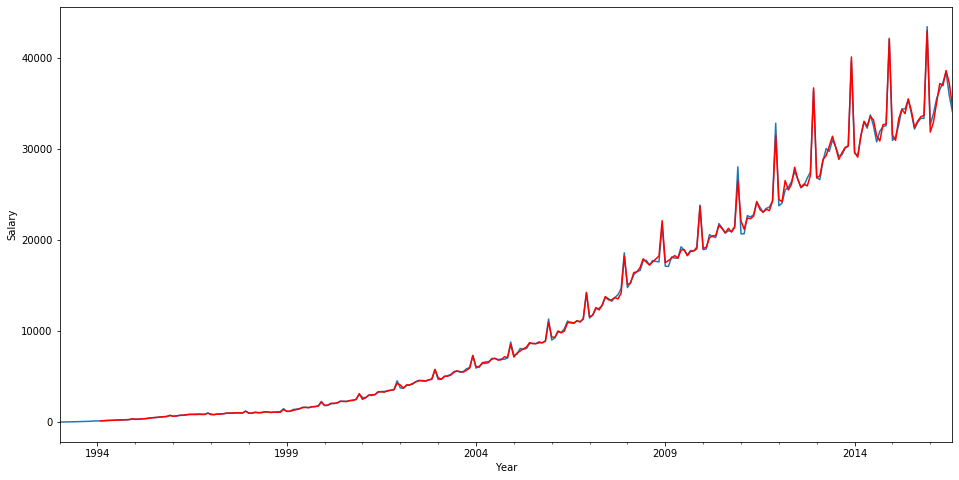

In [14]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(16,8))
data['salary'].plot()
data.model[13:].plot(color='r')
plt.ylabel('Salary')
plt.xlabel('Year')
pylab.show()

### 7. Прогнозирование с помощью финальной модели

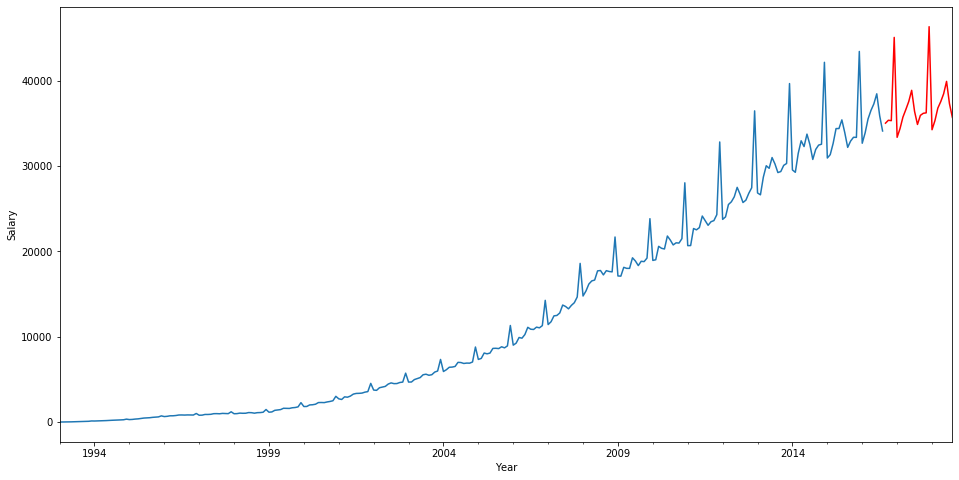

In [15]:
salary2 = data[['salary']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= salary2.columns)
salary2 = pd.concat([salary2, future])
salary2['forecast'] = invboxcox(best_model.predict(start=data.shape[0], end=data.shape[0]+24), lmbda)

plt.figure(figsize(16,8))
salary2['salary'].plot()
salary2['forecast'].plot(color='r')
plt.ylabel('Salary')
plt.xlabel('Year')
pylab.show()